<a href="https://www.kaggle.com/code/olgaianina/titanic-randomforest?scriptVersionId=103917392" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
#Read csv to pandas dataframe
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

In [3]:
#Train data
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Test data
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


<AxesSubplot:xlabel='Pclass', ylabel='Count'>

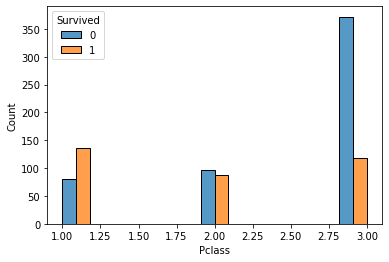

In [7]:
#In the graph below we can see that most of the survivors are in the first class, and most of the dead are in the third.
sns.histplot(data=train_data, x='Pclass', hue='Survived', multiple='dodge')

In [8]:
#Here we see that more women survived than men
t = train_data.groupby('Sex').aggregate({'PassengerId':'count','Survived':'sum'}).rename(columns={'PassengerId':'TotalNumber'})
t.assign(Percent_of_surv=round(t.Survived/t.TotalNumber*100,2))

,TotalNumber,Survived,Percent_of_surv
Sex,,,
female,314,233,74.20
male,577,109,18.89


In [9]:
#We see null data in 3 columns in train data: Age (714), Cabin (204) and Embarked (889). And 3 columns in test data: Age(332), Fare (417) and Cabin (91).
#Column "Cabin" has too much null data in both dataframes. Let's delete it:
train_data.drop(['Cabin'], axis=1, inplace=True)
test_data.drop(['Cabin'], axis=1, inplace=True)
#We fill later other columns with null data 

In [10]:
#Save PassengerId for test data in pandas series
test_id = test_data['PassengerId']
#Now we can delete column "PassengerId" from both dataframes:
train_data.drop(['PassengerId'], axis=1, inplace=True)
test_data.drop(['PassengerId'], axis=1, inplace=True)

In [11]:
#Extract title from 'Name'. The title is after a comma and ends with a dot in 'Name' field.
train_data['Title'] = train_data.Name.str.extract(r',\s([\w]*[\s]?[\w]*)\.')[0]
test_data['Title'] = test_data.Name.str.extract(r',\s([\w]*[\s]?[\w]*)\.')[0]

In [12]:
#Check that the new column has no gaps:
print('train: ', train_data.Title.isna().sum())
print('test: ',test_data.Title.isna().sum())

train:  0
test:  0


In [13]:
#Count how many survivors are in each Title. See also that women have survival rate higher than men.
train_title = train_data.groupby('Title').agg({'Title':'count','Survived':'sum'})
train_title = train_title.assign(percent_of_surv=round(train_title.Survived/train_title.Title*100,2))
train_title.sort_values('percent_of_surv')

,Title,Survived,percent_of_surv
Title,,,
Capt,1,0,0.00
Don,1,0,0.00
Jonkheer,1,0,0.00
Rev,6,0,0.00
Mr,517,81,15.67
Dr,7,3,42.86
Col,2,1,50.00
Major,2,1,50.00
Master,40,23,57.50


In [14]:
#Mr = Mister, Dr = Doctor, Rev = Reverend, Mlle = Mademoiselle(Fr) = Miss, Mme = Madame(Fr) = Mrs,
#Ms = Miss, Col = Colonel, Capt = Captain, Don = Sir, Dona = Mrs
#Replace 
train_data['Title'] = train_data['Title'].replace(['Mlle','Ms','Lady'],'Miss')
train_data['Title'] = train_data['Title'].replace(['Mme','the Countess'],'Mrs')
train_data['Title'] = train_data['Title'].replace(['Master','Major','Don','Jonkheer','Sir'],'Mr')
train_data['Title'] = train_data['Title'].replace(['Col', 'Capt', 'Dr', 'Rev'],'Other')
#-----
test_data['Title'] = test_data['Title'].replace('Ms','Miss')
test_data['Title'] = test_data['Title'].replace('Master','Mr')
test_data['Title'] = test_data['Title'].replace(['Col', 'Capt', 'Dr', 'Rev'],'Other')
test_data['Title'] = test_data['Title'].replace('Dona','Mrs')

In [15]:
train_data['Title'].value_counts()

Mr       562
Miss     186
Mrs      127
Other     16
Name: Title, dtype: int64

In [16]:
test_data['Title'].value_counts()

Mr       261
Miss      79
Mrs       73
Other      5
Name: Title, dtype: int64

In [17]:
#We can delete column "Name":
train_data.drop(['Name'], axis=1, inplace=True)
test_data.drop(['Name'], axis=1, inplace=True)

In [18]:
#Make columns 'Pair' and 'Alone' to show passengers who travels alone
train_data['Pair'] = train_data['SibSp'] + train_data['Parch']
train_data['Alone'] = np.where(train_data['Pair']==0,1,0)
test_data['Pair'] = test_data['SibSp'] + test_data['Parch']
test_data['Alone'] = np.where(test_data['Pair']==0,1,0)

<AxesSubplot:>

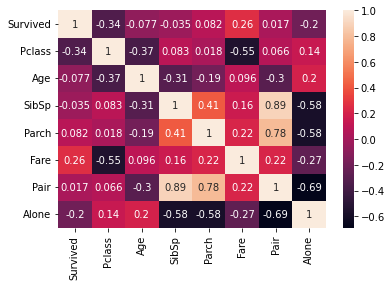

In [19]:
#Let's show correlation between Survived and other columns
sns.heatmap(data=train_data.corr(), annot=True)

In [20]:
#In the graph above we see that columns SibSp, Parch and Pair have less correlation with Survived than column Alone. Delete them:
train_data.drop(['SibSp','Parch','Pair'], axis=1, inplace=True)
test_data.drop(['SibSp','Parch','Pair'], axis=1, inplace=True)

In [21]:
#Percentage of unique values of column Ticket
print("train data: ", train_data.Ticket.value_counts().count()/train_data.shape[0])
print("test data: ", test_data.Ticket.value_counts().count()/test_data.shape[0])

train data:  0.7643097643097643
test data:  0.868421052631579


In [22]:
#Let's drop column Ticket because of large set of values.
train_data.drop(['Ticket'], axis=1, inplace=True)
test_data.drop(['Ticket'], axis=1, inplace=True)

In [23]:
train_data.describe()

,Survived,Pclass,Age,Fare,Alone
count,891.000000,891.000000,714.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,32.204208,0.602694
std,0.486592,0.836071,14.526497,49.693429,0.489615
min,0.000000,1.000000,0.420000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,7.910400,0.000000
50%,0.000000,3.000000,28.000000,14.454200,1.000000
75%,1.000000,3.000000,38.000000,31.000000,1.000000
max,1.000000,3.000000,80.000000,512.329200,1.000000


In [24]:
test_data.describe()

,Pclass,Age,Fare,Alone
count,418.000000,332.000000,417.000000,418.000000
mean,2.265550,30.272590,35.627188,0.605263
std,0.841838,14.181209,55.907576,0.489380
min,1.000000,0.170000,0.000000,0.000000
25%,1.000000,21.000000,7.895800,0.000000
50%,3.000000,27.000000,14.454200,1.000000
75%,3.000000,39.000000,31.500000,1.000000
max,3.000000,76.000000,512.329200,1.000000


In [25]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   Fare      891 non-null    float64
 5   Embarked  889 non-null    object 
 6   Title     891 non-null    object 
 7   Alone     891 non-null    int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 55.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   Fare      417 non-null    float64
 4   Embarked  418 non-null    object 
 5   Title     418 non-null    object 
 6   Alone     418 non-null

In [26]:
#Remember column Survived from train data and delete it. It is necessary for transform data
train_y = train_data['Survived']
train_data.drop(['Survived'], axis=1, inplace=True)

In [27]:
#Transform columns. Fill numerical columns (Age and Fare) with median values and scale them. Fill categorical columns with most frequent values and 
#transform them into numeric view.
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
num_cols = ['Age','Fare']
cat_cols = [col for col in train_data.columns if col not in num_cols]
num_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder',OrdinalEncoder())
])
preproc = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])
train_data = pd.DataFrame(preproc.fit_transform(train_data))
train_data.columns = num_cols+cat_cols
test_data = pd.DataFrame(preproc.fit_transform(test_data))
test_data.columns = num_cols+cat_cols

In [28]:
train_data.head()

,Age,Fare,Pclass,Sex,Embarked,Title,Alone
0,-0.565736,-0.502445,2.0,1.0,2.0,1.0,0.0
1,0.663861,0.786845,0.0,0.0,0.0,2.0,0.0
2,-0.258337,-0.488854,2.0,0.0,2.0,0.0,1.0
3,0.433312,0.420730,0.0,0.0,2.0,2.0,0.0
4,0.433312,-0.486337,2.0,1.0,2.0,1.0,1.0


In [29]:
test_data.head()

,Age,Fare,Pclass,Sex,Embarked,Title,Alone
0,0.386231,-0.497413,2.0,1.0,1.0,1.0,1.0
1,1.371370,-0.512278,2.0,0.0,2.0,2.0,0.0
2,2.553537,-0.464100,1.0,1.0,1.0,1.0,1.0
3,-0.204852,-0.482475,2.0,1.0,2.0,1.0,1.0
4,-0.598908,-0.417492,2.0,0.0,2.0,2.0,0.0


In [30]:
#Make class weight
w0 = round(train_y.value_counts()[0]/len(train_y),2)
class_wt = {0: w0, 1: 1 - w0}
class_wt

{0: 0.62, 1: 0.38}

In [31]:
#We will predict data
#Import required moduls
#For selection of parameters:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [32]:
#Random Forest
parameters = {'criterion': ['entropy','gini'], 'max_depth': range(2,13),    
              'min_samples_split':range(2,5),'min_samples_leaf':range(1,5)
             }
rs_rf = GridSearchCV(RandomForestClassifier(random_state = 0, n_jobs = -1, class_weight = class_wt
                                           ), parameters, cv = 5)
rs_rf.fit(train_data, train_y)
print(rs_rf.best_params_)
print(round(rs_rf.score(train_data, train_y)*100,2))

{'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 2}
94.73


In [33]:
#Predict test data
rf = RandomForestClassifier(random_state = 0, n_jobs = -1, n_estimators = 10000, bootstrap = False, criterion = 'entropy',
                            max_depth = 11, min_samples_leaf = 1, min_samples_split = 2,  class_weight = class_wt)
rf.fit(train_data, train_y)
y_pred_rf = rf.predict(test_data)
print(round(rf.score(train_data, train_y)*100,2))

95.06


In [34]:
#Export results to files
result_data = pd.DataFrame()
result_data['PassengerId']=test_id
result_data['Survived'] = y_pred_rf
result_data.to_csv("submission.csv", index=False)